In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

from sklearn.feature_extraction.text import CountVectorizer
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
# from keras.utils.np_utils import to_categorical

from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

pd.set_option("display.max_columns", None)

In [28]:
clean_df = pd.read_csv("./datasets/datafiniti/1429_1.csv", low_memory=False, 
                 usecols=['reviews.text', 'reviews.rating'])
clean_df['reviews.sentiment'] = clean_df['reviews.rating'].apply(lambda x: 1 if x >= 4.0 else 0)
clean_df.head()

reviews.rating                                       reviews.text  \
0             5.0  This product so far has not disappointed. My c...   
1             5.0  great for beginner or experienced person. Boug...   
2             5.0  Inexpensive tablet for him to use and learn on...   
3             4.0  I've had my Fire HD 8 two weeks now and I love...   
4             5.0  I bought this for my grand daughter when she c...   

   reviews.sentiment  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1

In [29]:
clean_df = clean_df.dropna()

In [30]:
scraped_df = pd.read_csv("./datasets/Reviews.csv", low_memory=False,
                         usecols=['reviews.text', 'reviews.rating'])
scraped_df['reviews.sentiment'] = scraped_df['reviews.rating'].apply(lambda x: 1 if x >= 4.0 else 0)
scraped_df = scraped_df.dropna()

In [6]:
# scraped_df['reviews.text'].to_list()[:500]

In [31]:
scraped_df.isna().sum()

reviews.rating       0
reviews.text         0
reviews.sentiment    0
dtype: int64

In [32]:
df = pd.concat([clean_df, scraped_df])

In [33]:
df = df[['reviews.text', 'reviews.sentiment']]

In [34]:
print(f"Positive labels %: {(df['reviews.sentiment'].value_counts()[0]/len(df)) * 100:.3f}")
print(f"Negative labels %: {(df['reviews.sentiment'].value_counts()[1]/len(df)) * 100:.3f}")
df['reviews.sentiment'].value_counts().plot(kind='bar')

Positive labels %: 40.330
Negative labels %: 59.670


<AxesSubplot:>

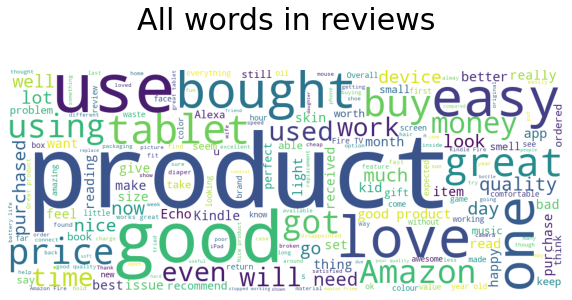

In [35]:
text = df['reviews.text']
wordcloud = WordCloud(background_color='white',
                     width=1000,
                     height=400).generate(" ".join(text))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title("All words in reviews\n", size=30)
plt.axis('off')
plt.show()

In [12]:
# max_features = 2000
# tokenizer = Tokenizer(num_words=max_features, split=' ')
# tokenizer.fit_on_texts(df['reviews.text'].values)
# X = tokenizer.texts_to_sequences(df['reviews.text'].values)
# X = pad_sequences(X)

In [13]:
# embed_dim = 128
# lstm_out = 196

# model = Sequential()
# model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
# model.add(SpatialDropout1D(0.4))
# model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(2,activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())

In [36]:
#lowercase all text
df['reviews.text'] = df['reviews.text'].str.lower()

#tokenization
df['reviews.text'] = df.apply(lambda row: word_tokenize(
    row['reviews.text']), axis=1)

In [37]:
df['reviews.text'] = df['reviews.text'].apply(
    lambda x:[item for item in x if item.isalpha()])

#lemmatize
df['reviews.text'] = df['reviews.text'].apply(
    lambda x:[WordNetLemmatizer().lemmatize(y) for y in x])

#remove stopwords
stop_words = stopwords.words('english')
df['reviews.text'] = df['reviews.text'].apply(
    lambda x:[item for item in x if item not in stop_words])

In [38]:
df['reviews.text'] = df['reviews.text'].apply(
    lambda x:str(' '.join(x)))

In [39]:
df.head()

reviews.text  reviews.sentiment
0  product far ha disappointed child love use lik...                  1
1  great beginner experienced person bought gift ...                  1
2  inexpensive tablet use learn step nabi wa thri...                  1
3  fire hd two week love tablet great prime membe...                  1
4  bought grand daughter come visit set user ente...                  1

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2)) 
text = vectorizer.fit_transform(df['reviews.text'])

In [41]:
print(text.shape)

(91995, 506915)


In [42]:
X_train, X_test, y_train, y_test = train_test_split(text, 
                                                    df['reviews.sentiment'],
                                                    test_size=0.2,
                                                    random_state=420)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

from sklearn.metrics import classification_report

print("Training Classification Report:")
print(classification_report(y_train, y_pred_train))
print()
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88     29643
           1       0.89      0.97      0.93     43953

    accuracy                           0.91     73596
   macro avg       0.92      0.89      0.90     73596
weighted avg       0.91      0.91      0.91     73596


Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      7459
           1       0.83      0.94      0.88     10940

    accuracy                           0.85     18399
   macro avg       0.86      0.83      0.84     18399
weighted avg       0.85      0.85      0.84     18399



In [44]:
input_text = """I am only using it for 1 week. Thus I have no idea about how long it will last, but the product quality seems very good. My foot is around 25.6-25.8 and I ordered size 8. It fits perfectly. The only thing I didn't like is the Laces. They seemed very long to me and the flat laces often get loose. The shoe attracts dust and can be easily cleaned with a dry cloth. However, I am very happy with the product. Nice quality
and design at the affordable price range (I bought the blue one at Rs 719 - Rs 50, UPI offer)."""
input_text = word_tokenize(input_text.lower())
input_text = [word for word in input_text if word.isalpha()]
input_text = [WordNetLemmatizer().lemmatize(word) for word in input_text]
input_text = [word for word in input_text if word not in stop_words]

input_text = vectorizer.transform(input_text)

print(input_text.shape)

(49, 506915)


In [45]:
print(model.predict(input_text)[0])

1


In [46]:
res=model.predict(input_text)[0]
if res==1:
    print("Good Review")
elif res==0:
    print("Bad Review")

Good Review


In [47]:
import pickle

file = open("./models/nb_model.pkl", 'wb')

pickle.dump(model, file)

file.close()

In [48]:
file2 = open("./models/tfidf_model_ngram.pkl", 'wb')
pickle.dump(vectorizer, file2)
file2.close()

In [71]:
# df['reviews.text'] = df['reviews.text'].apply(lambda x: x.lower())
# df['reviews.text'] = df['reviews.text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))
# df['reviews.text'] = df['reviews.text'].apply(lambda x: x.replace('.', ' '))

In [ ]:
# Y = pd.get_dummies(df['reviews.sentiment']).values
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2,
#                                                     random_state = 42)
# print(X_train.shape,Y_train.shape)
# print(X_test.shape,Y_test.shape)

In [ ]:
# from tqdm.keras import TqdmCallback
# batch_size = 1024
# model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, 
#           verbose=0, callbacks=[TqdmCallback(verbose=2)])